## Bayesian Networks on Heart disease dataset

In [1]:
import bnlearn
import pomegranate
import wget
import os
import pandas as pd
import numpy as np
import pgmpy
from sklearn.model_selection import train_test_split
import ucimlr

#ucimlr.all_datasets()

In [2]:

df = pd.read_csv('../data/heart.csv')
df.head()
df = df.rename(columns={'target': 'heartdisease'})
df.head()

#sex: sex (1 = male; 0 = female)
#cp: chest pain type
#-- Value 1: typical angina
#-- Value 2: atypical angina
#-- Value 3: non-anginal pain
#-- Value 4: asymptomatic
#chol: serum cholestoral in mg/dl
#fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
#restecg: resting electrocardiographic results
#-- Value 0: normal
#-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
#-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
#thalach: maximum heart rate achieved
#thalrest: resting heart rate

#oldpeak = ST depression induced by exercise relative to rest
#slope: the slope of the peak exercise ST segment
#-- Value 1: upsloping
#-- Value 2: flat
#-- Value 3: downsloping

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heartdisease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
X_cols =['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs','restecg', 'thalach', 'exang']
y_col = ['heartdisease']

df_filter = df.loc[:, X_cols + y_col]
df_filter = df_filter.replace('?', np.nan)
y = df_filter.loc[:, 'heartdisease'].values
x = df_filter.drop('heartdisease', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

In [4]:

train_df = pd.concat([pd.DataFrame(X_train, columns=X_cols), pd.Series(y_train, name=y_col[0])], axis=1)
test_df = pd.concat([pd.DataFrame(X_test, columns=X_cols), pd.Series(y_train, name=y_col[0])], axis=1)

[bnlearn] >Bayesian DAG created.
[bnlearn] >Plot based on BayesianModel


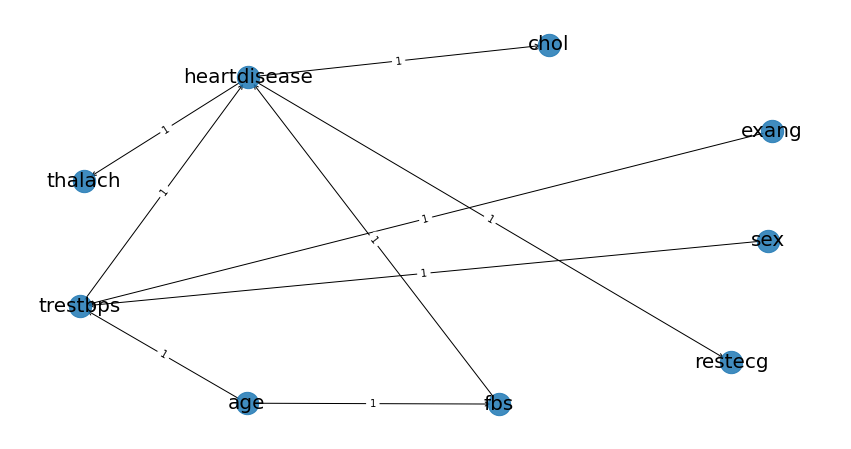

{'pos': {'age': array([-0.48587082, -0.84565628]),
  'trestbps': array([-0.90126611, -0.34717481]),
  'fbs': array([ 0.14192771, -0.85006152]),
  'sex': array([ 0.81140201, -0.00822954]),
  'exang': array([0.82047712, 0.55512316]),
  'heartdisease': array([-0.48192664,  0.83261658]),
  'restecg': array([ 0.72049802, -0.63566014]),
  'thalach': array([-0.89152844,  0.29904255]),
  'chol': array([0.26628715, 1.        ])},
 'G': <networkx.classes.digraph.DiGraph at 0x7f8c61238430>}

In [5]:


edges = [('age', 'trestbps'), ('age', 'fbs'), ('sex', 'trestbps'), ('sex', 'trestbps'), 
                       ('exang', 'trestbps'),('trestbps','heartdisease'),('fbs','heartdisease'),
                      ('heartdisease','restecg'),('heartdisease','thalach'),('heartdisease','chol')]



# Create the DAG from the edges
DAG = bnlearn.make_DAG(edges)

# Plot and make sure the arrows are correct.
bnlearn.plot(DAG)



### Structured learning - compute best dag from dataset

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Plot based on BayesianModel


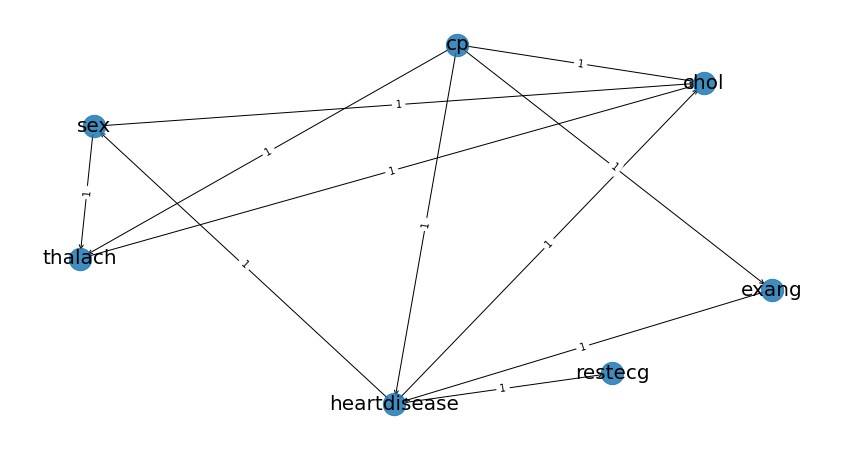

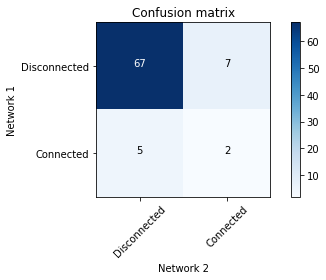

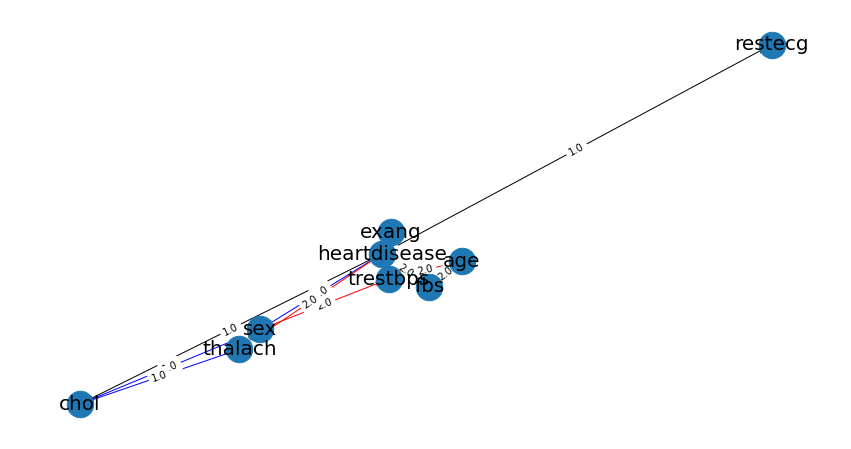

(array([[67,  7],
        [ 5,  2]]),
 target        age  sex  trestbps  chol  fbs  restecg  thalach  exang  \
 source                                                                 
 age             0    0         2     0    2        0        0      0   
 sex             0    0         2    -1    0        0       -1      0   
 trestbps        0    0         0     0    0        0        0      0   
 chol            0    0         0     0    0        0        0      0   
 fbs             0    0         0     0    0        0        0      0   
 restecg         0    0         0     0    0        0        0      0   
 thalach         0    0         0    -1    0        0        0      0   
 exang           0    0         2     0    0        0        0      0   
 heartdisease    0   -1         0     1    0        1        2      0   
 
 target        heartdisease  
 source                      
 age                      0  
 sex                      0  
 trestbps                 2  
 chol  

In [6]:

from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator




# Structure learning on the data set
#model = bnlearn.structure_learning.fit(train_df)
model = bnlearn.structure_learning.fit(df_filter)
# [bnlearn] >Computing best DAG using [hc]
# [bnlearn] >Set scori4ng type at [bic]
# Plot the DAG
bnlearn.plot(model)
# Plot differences between expert-DAG and the computed-DAG
bnlearn.compare_networks(model, DAG)

In [7]:
model = BayesianModel([('age', 'trestbps'), ('age', 'fbs'), ('sex', 'trestbps'), ('sex', 'trestbps'), 
                       ('exang', 'trestbps'),('trestbps','heartdisease'),('fbs','heartdisease'),
                      ('heartdisease','restecg'),('heartdisease','thalach'),('heartdisease','chol')])

#Learing CPDs using Maximum Likelihood Estimators
model.fit(df_filter, estimator=BayesianEstimator)

print(model.get_cpds('age'))

+---------+------------+
| age(29) | 0.0036427  |
+---------+------------+
| age(34) | 0.00688945 |
+---------+------------+
| age(35) | 0.013383   |
+---------+------------+
| age(37) | 0.00688945 |
+---------+------------+
| age(38) | 0.0101362  |
+---------+------------+
| age(39) | 0.013383   |
+---------+------------+
| age(40) | 0.0101362  |
+---------+------------+
| age(41) | 0.0328635  |
+---------+------------+
| age(42) | 0.02637    |
+---------+------------+
| age(43) | 0.02637    |
+---------+------------+
| age(44) | 0.0361102  |
+---------+------------+
| age(45) | 0.02637    |
+---------+------------+
| age(46) | 0.0231232  |
+---------+------------+
| age(47) | 0.0166297  |
+---------+------------+
| age(48) | 0.0231232  |
+---------+------------+
| age(49) | 0.0166297  |
+---------+------------+
| age(50) | 0.0231232  |
+---------+------------+
| age(51) | 0.039357   |
+---------+------------+
| age(52) | 0.0426037  |
+---------+------------+
| age(53) | 0.02637    |


### Computing probability of variable

What is probability of heart disease given someone is male ?


In [10]:
# Doing exact inference using Variable Elimination
from pgmpy.inference import VariableElimination
HeartDisease_infer = VariableElimination(model)

# Computing the probability of bronc given smoke.
q = HeartDisease_infer.query(variables=['heartdisease'], evidence={'sex': 1})
print(q)

Eliminating: exang: 100%|██████████| 7/7 [00:00<00:00, 407.94it/s]

+-----------------+---------------------+
| heartdisease    |   phi(heartdisease) |
+=================+=====================+
| heartdisease(0) |              0.4665 |
+-----------------+---------------------+
| heartdisease(1) |              0.5335 |
+-----------------+---------------------+


In [11]:
print(model.get_cpds('sex'))

+--------+----------+
| sex(0) | 0.319805 |
+--------+----------+
| sex(1) | 0.680195 |
+--------+----------+
